In [41]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import metrics
from sklearn.metrics import classification_report, accuracy_score
import seaborn as sns
from matplotlib import pyplot as plt
import regex as re
from sklearn.feature_extraction.text import CountVectorizer
import collections
from sklearn_pandas import DataFrameMapper
from collections import Counter


In [42]:
train_file = pd.read_csv('../data/augmented_training_file/final_train_file.csv')
final_test_file = pd.read_csv('../data/test.csv')


In [43]:
train_file.dropna(inplace=True)

In [44]:
data_per_class = Counter(train_file['label'])
print("Number of rows grouped by label are:")
for i, label in enumerate(data_per_class):
    print(
        f"{label} class rows: {data_per_class[label]} ({data_per_class[label] / train_file.shape[0]*100:.3f})% of total train data")


Number of rows grouped by label are:
0 class rows: 175598 (56.777)% of total train data
2 class rows: 59447 (19.221)% of total train data
1 class rows: 74231 (24.002)% of total train data


In [45]:
def combine_titles(text):
    return (text['title1_en']+" "+text['title2_en'])

train_file['combined_titles'] = train_file[['title1_en', 'title2_en']].apply(combine_titles, axis=1)
final_test_file['combined_titles'] = final_test_file[['title1_en', 'title2_en']].apply(combine_titles, axis=1)


In [46]:
train_split, validation_split = train_test_split(train_file, test_size=0.3,stratify=train_file['label'],random_state=9)

In [47]:
vectorizer = TfidfVectorizer(stop_words="english", strip_accents="unicode", lowercase=False, encoding='utf-8', min_df=3).fit(train_split['combined_titles'])


In [48]:
train_data=vectorizer.transform(train_split['combined_titles'])
train_labels=train_split['label']

In [49]:
logistic_regression_model = LogisticRegression(penalty="l2",solver="lbfgs",multi_class="multinomial",max_iter=5000, C=0.9).fit(train_data, train_labels)

In [50]:
logistic_regression_model.score(train_data, train_labels)


0.8453391102714637

In [62]:
train_hat_labels = logistic_regression_model.predict(train_data)
print(classification_report(train_labels, train_hat_labels))


              precision    recall  f1-score   support

           0       0.83      0.92      0.87    122918
           1       0.80      0.66      0.72     51962
           2       0.95      0.87      0.91     41613

    accuracy                           0.85    216493
   macro avg       0.86      0.81      0.83    216493
weighted avg       0.85      0.85      0.84    216493



[0 1 2]


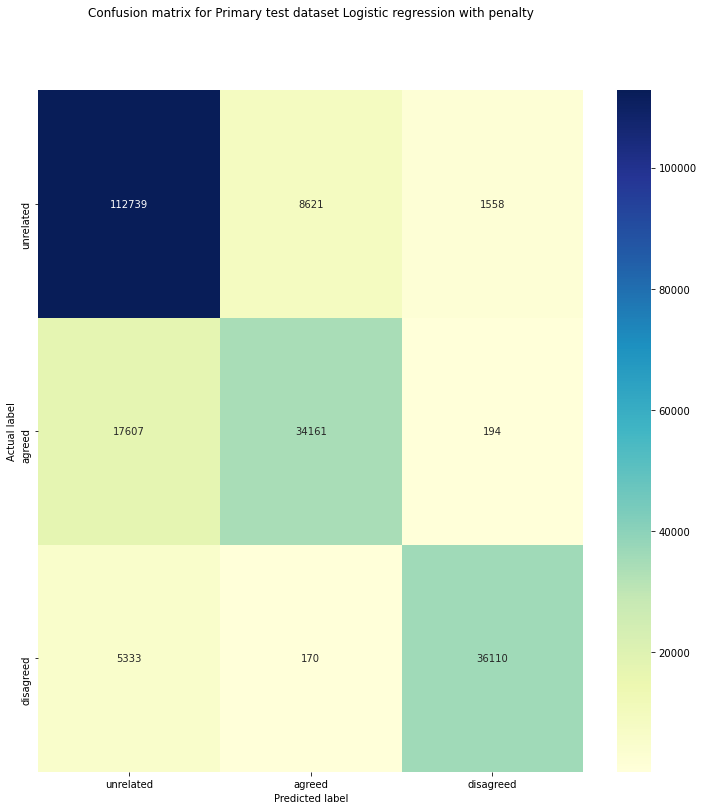

In [51]:
cnf_matrix_l1_primary_dataset = metrics.confusion_matrix(
    train_labels, train_hat_labels)
%matplotlib inline
class_names = ["unrelated", "agreed", "disagreed"]  # name  of classes
# fig, ax = plt.subplots()
plt.figure(figsize=(10, 10))
tick_marks = np.arange(len(class_names))
print(tick_marks)
plt.xticks([0, 1, 2], class_names)
plt.yticks([0, 1, 2], class_names)
# create heatmap
sns.heatmap(pd.DataFrame(cnf_matrix_l1_primary_dataset), annot=True,
            cmap="YlGnBu", fmt='g', xticklabels=class_names, yticklabels=class_names)
plt.tight_layout()
plt.title(
    'Confusion matrix for Primary test dataset Logistic regression with penalty', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

plt.show()


In [52]:
valid_data=vectorizer.transform(validation_split['combined_titles'])
valid_labels=validation_split['label']

In [53]:
logistic_regression_model.score(valid_data, valid_labels)


0.8128859812681203

In [54]:
valid_hat_labels=logistic_regression_model.predict(valid_data)
valid_hat_labels


array([0, 0, 0, ..., 0, 0, 0], dtype=int64)

In [63]:
print(classification_report(valid_labels, valid_hat_labels),end="")

              precision    recall  f1-score   support

           0       0.80      0.89      0.85     52680
           1       0.73      0.60      0.66     22269
           2       0.94      0.84      0.89     17834

    accuracy                           0.81     92783
   macro avg       0.82      0.78      0.80     92783
weighted avg       0.81      0.81      0.81     92783
              precision    recall  f1-score   support

           0       0.83      0.92      0.87    122918
           1       0.80      0.66      0.72     51962
           2       0.95      0.87      0.91     41613

    accuracy                           0.85    216493
   macro avg       0.86      0.81      0.83    216493
weighted avg       0.85      0.85      0.84    216493



[0 1 2]


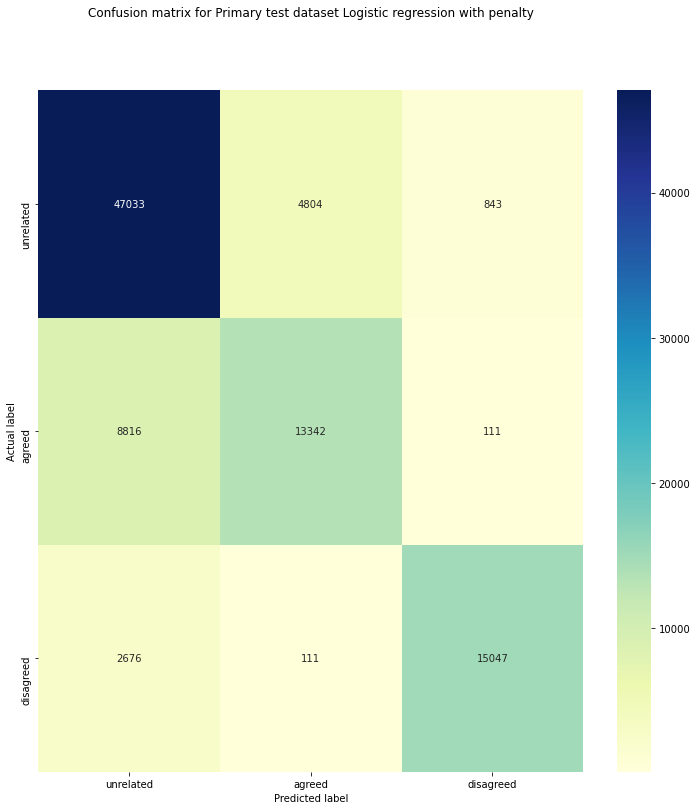

In [56]:
cnf_matrix_l1_primary_dataset = metrics.confusion_matrix(
    valid_labels, valid_hat_labels)
%matplotlib inline
class_names = ["unrelated", "agreed", "disagreed"]  # name  of classes
# fig, ax = plt.subplots()
plt.figure(figsize=(10, 10))
tick_marks = np.arange(len(class_names))
print(tick_marks)
plt.xticks([0, 1, 2], class_names)
plt.yticks([0, 1, 2], class_names)
# create heatmap
sns.heatmap(pd.DataFrame(cnf_matrix_l1_primary_dataset), annot=True,
            cmap="YlGnBu", fmt='g', xticklabels=class_names, yticklabels=class_names)
plt.tight_layout()
plt.title(
    'Confusion matrix for Primary test dataset Logistic regression with penalty', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

plt.show()


In [57]:
final_test_data=vectorizer.transform(final_test_file['combined_titles'])

In [58]:
final_test_file['label']=logistic_regression_model.predict(final_test_data)


In [59]:
label_decoding = {0: "unrelated", 1: "agreed", 2:"disagreed"}

def convert_labels_to_class(txt):
    return label_decoding[txt]


final_test_file['label'] = final_test_file['label'].apply(convert_labels_to_class)


In [60]:
data_per_class = Counter(final_test_file['label'])
print("Number of rows grouped by label are:")
for i, label in enumerate(data_per_class):
    print(
        f"{label} class rows: {data_per_class[label]} ({data_per_class[label] / final_test_file.shape[0]*100:.3f})% of total train data")


Number of rows grouped by label are:
unrelated class rows: 44440 (69.318)% of total train data
agreed class rows: 17949 (27.997)% of total train data
disagreed class rows: 1721 (2.684)% of total train data


In [61]:
final_test_file[['id','label']].to_csv("../data/simple_logistic_regression_test_output_predictions.csv",index=False)